# Machine Learning for Life Science: Project 2 - Multilabel Protein Localization Prediction

# DATA

In [1]:
import os
import sys
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer

train_labels = './data/train.csv'
train_images = './data/train/'

test_submission = './data/submission.csv'
test_images = './data/test/'

label_map = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles',
}

# variable for device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


   Image Label
0  12874   1 4
1  21466     0
2   3610     4 

   Image  0  1  2  3  4  5  6  7  8  9
0  12874  0  1  0  0  1  0  0  0  0  0
1  21466  1  0  0  0  0  0  0  0  0  0
2   3610  0  0  0  0  1  0  0  0  0  0


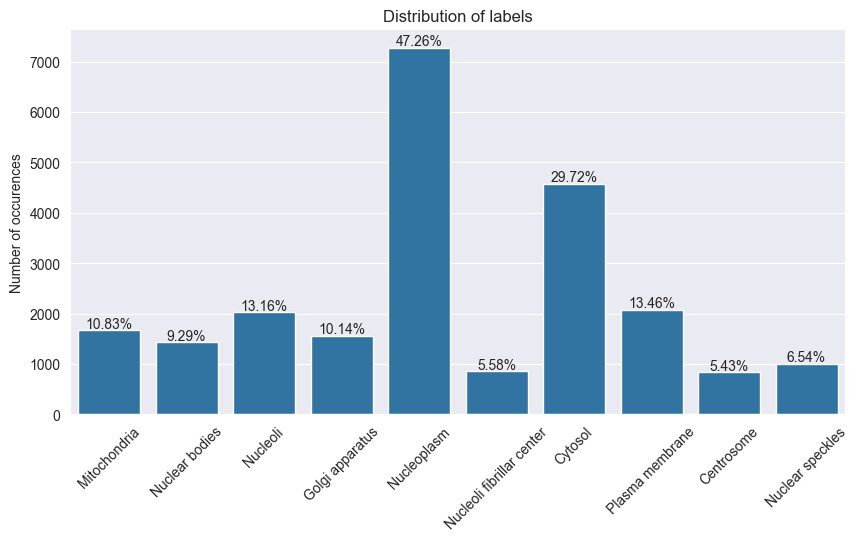

In [2]:
df = pd.read_csv(train_labels)
print(df.head(3), '\n')
mlb = MultiLabelBinarizer()
df['Label'] = df['Label'].apply(lambda x: x.split(' '))
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('Label')),
                          columns=mlb.classes_,
                          index=df.index))
print(df.head(3))

# plot the distribution of labels with seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=df.columns[1:], y=df.iloc[:, 1:].sum().values)
plt.title("Distribution of labels")
plt.ylabel("Number of occurences")
plt.xlabel("")
plt.xticks(range(10), [label_map[i] for i in range(10)])
plt.xticks(rotation=45)
for i, v in enumerate(df.iloc[:, 1:].sum().values):
    ax.text(i, v + 50, str(np.round(100 * v / df.shape[0], 2)) + '%', ha="center")
plt.show()

In [3]:
# multi-label stratified split of the dataset into train and validation sets
from skmultilearn.model_selection import iterative_train_test_split

X = df['Image']
y = df.drop(columns=['Image'])

X_train, y_train, X_val, y_val = iterative_train_test_split(X.values.reshape(-1, 1), y.values, test_size=0.1)
X_test = pd.read_csv(test_submission)['Image'].values.reshape(-1, 1)

print('Train:', X_train.shape, y_train.shape)
print('Val:', X_val.shape, y_val.shape)
print('Test:', X_test.shape)

Train: (13855, 1) (13855, 10)
Val: (1534, 1) (1534, 10)
Test: (3847, 1)


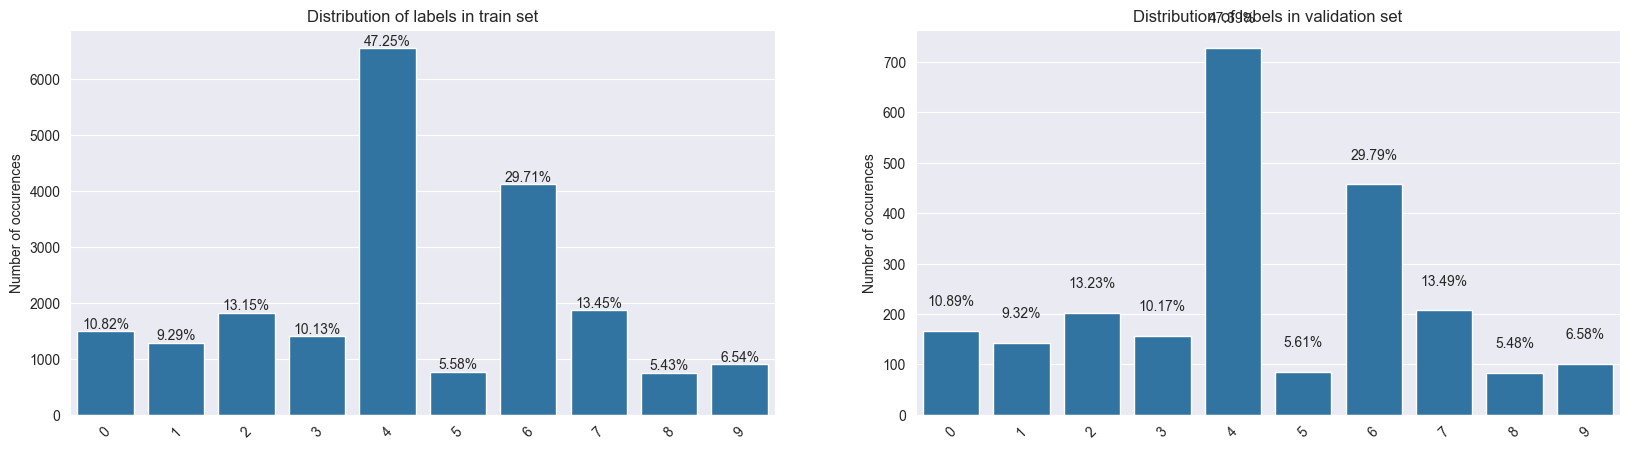

In [4]:
# plot distribution of labels in train and validation sets
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=range(10), y=y_train.sum(axis=0))
plt.title("Distribution of labels in train set")
plt.ylabel("Number of occurences")
plt.xlabel("")
plt.xticks(rotation=45)
for i, v in enumerate(y_train.sum(axis=0)):
    ax.text(i, v + 50, str(np.round(100 * v / y_train.shape[0], 2)) + '%', ha="center")

plt.subplot(1, 2, 2)
ax = sns.barplot(x=range(10), y=y_val.sum(axis=0))
plt.title("Distribution of labels in validation set")
plt.ylabel("Number of occurences")
plt.xlabel("")
plt.xticks(rotation=45)
for i, v in enumerate(y_val.sum(axis=0)):
    ax.text(i, v + 50, str(np.round(100 * v / y_val.shape[0], 2)) + '%', ha="center")
plt.show()

In [5]:
from torchvision import transforms

class HumanProteinDataset(Dataset):
    def __init__(self, X, y=None, data_dir='./data/train/', transform=None, balance_classes=False):
        super().__init__()

        self.data_dir = data_dir
        self.X = [data_dir + str(name) + '.png' for name in X[:, 0]]
        self.transform = transform
        if y is not None:
            self.y = y.astype(np.float32)

            if balance_classes:
                class_counts = y.sum(axis=0)
                self.class_weights = len(y) / (len(class_counts) * class_counts)
                self.sample_weights = torch.from_numpy(np.array([self.class_weights[class_idx] for class_idx in np.argmax(y, axis=1)]))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = read_image(self.X[index]) / 255.0
        if self.transform:
            image = self.transform(image)
        if hasattr(self, 'y'):
            label = torch.from_numpy(self.y[index])
            if hasattr(self, 'sample_weights'):
                return image, label, self.sample_weights[index]
            else:
                return image, label
        else:
            return image

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.RandomResizedCrop(128, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
])

train_dataset = HumanProteinDataset(X=X_train, y=y_train, data_dir=train_images, transform=train_transform, balance_classes=True)
val_dataset = HumanProteinDataset(X=X_val, y=y_val, data_dir=train_images)
test_dataset = HumanProteinDataset(X=X_test, data_dir=test_images)

Number of samples:  13855
Shape of image:  torch.Size([3, 128, 128])
Shape of label:  torch.Size([10]) 


Example image:


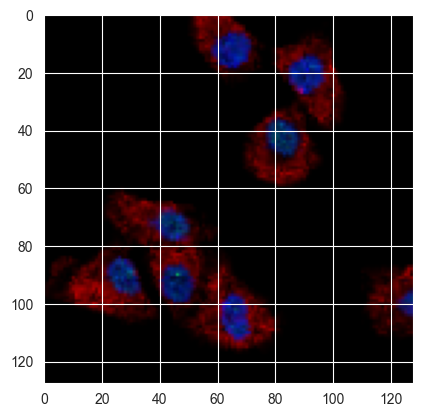

In [6]:
print('Number of samples: ', len(train_dataset))
print('Shape of image: ', train_dataset[0][0].shape)
print('Shape of label: ', train_dataset[0][1].shape, '\n\n')

print('Example image:')
plt.imshow(train_dataset.__getitem__(0)[0].permute(1, 2, 0))

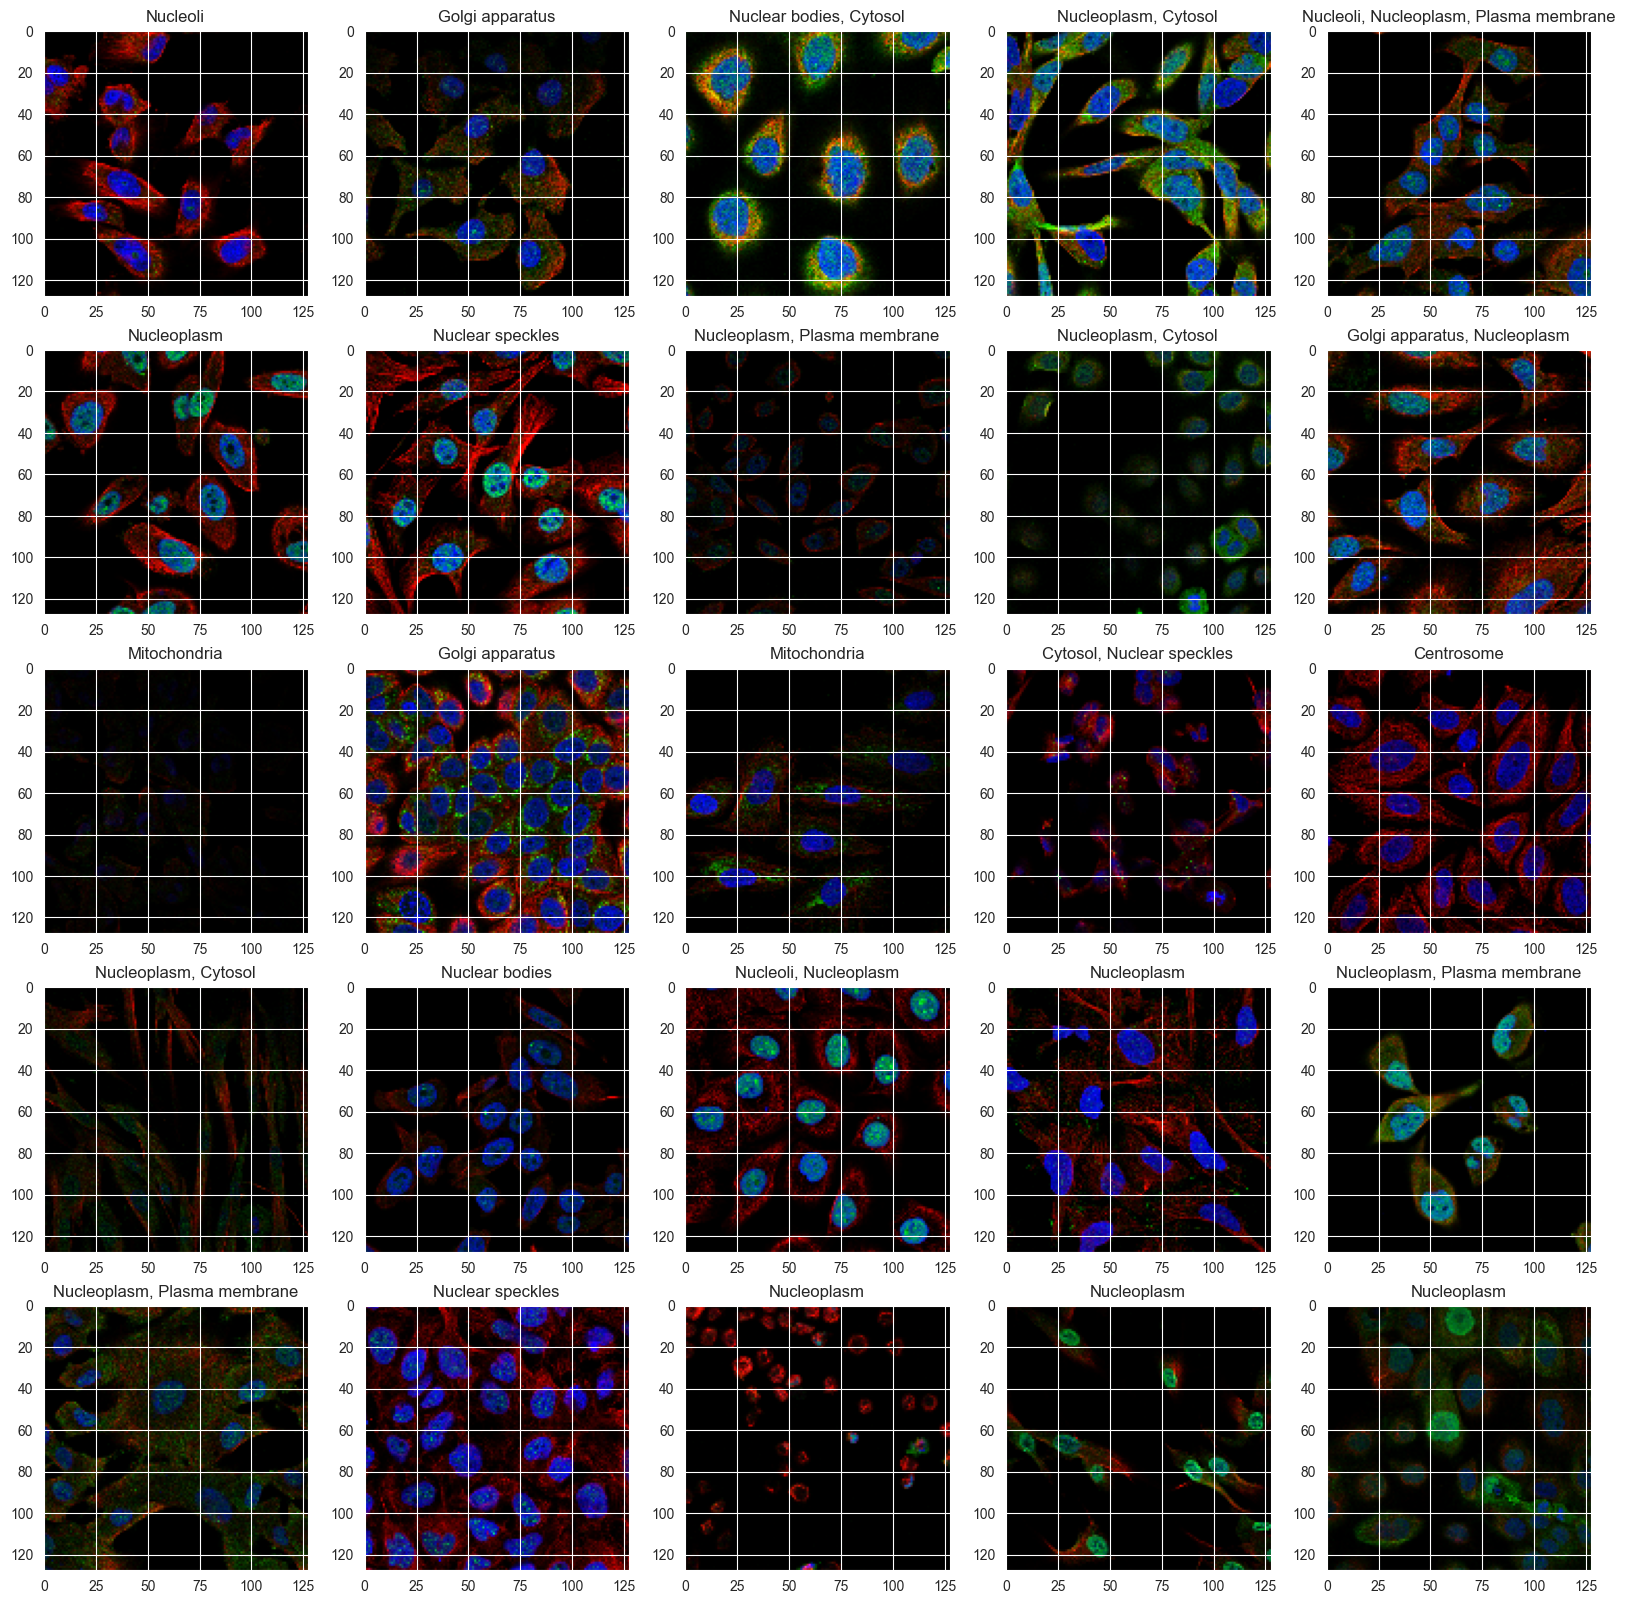

In [7]:
# plot several random train_dataset images with their labels (translated with label_map)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image, label = val_dataset[np.random.randint(0, len(val_dataset))]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(', '.join(list([label_map[i] for i in np.where(label)[0]])))
plt.show()

In [8]:
if hasattr(train_dataset, 'sample_weights'):
    train_sampler = torch.utils.data.WeightedRandomSampler(train_dataset.sample_weights.type('torch.DoubleTensor'), len(train_dataset))
    train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
else:
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# test dataloader
test_batch = train_dataloader.__iter__().__next__()
print('Test batch shape\n', test_batch[0].shape, test_batch[1].shape)

Test batch shape
 torch.Size([64, 3, 128, 128]) torch.Size([64, 10])


In [9]:
# example softmax and sigmoid output on a random batch
import torch.nn.functional as F

print(test_batch[1][0])
print('Softmax output:\n', F.softmax(test_batch[1], dim=1)[0])
print('Sigmoid output:\n', torch.sigmoid(test_batch[1][0]))

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Softmax output:
 tensor([0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853, 0.0853,
        0.0853])
Sigmoid output:
 tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.7311, 0.5000, 0.5000,
        0.5000])


In [10]:
# class ChannelAttentionBlock(nn.Module):
#     def __init__(self, channels = 64):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(channels, channels, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att

# class SpatialAttentionBlock(nn.Module):
#     def __init__(self, channels = 64):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(channels, 1, 1),
#             nn.BatchNorm2d(1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att


# class ResidualBlock(nn.Module):
#     def __init__(self, channels = 64, kernel_size = 3):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(channels, channels, kernel_size, padding = "same"),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(),
#             nn.Conv2d(channels, channels, kernel_size, padding = "same"),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(),
#             )

#         self.att_c = ChannelAttentionBlock(channels)
#         self.att_s = SpatialAttentionBlock(channels)

#     def forward(self, x):
#         out = self.net(x)
#         att_c = self.att_c(out)
#         att_s = self.att_s(out)
#         # normalize attention weights
#         att_c = att_c / (att_c + att_s)
#         att_s = att_s / (att_c + att_s)
#         # apply attention weights
#         out = (out * att_c) + (out * att_s)

#         return out + x


# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size = 3, dropout_rate = 0.3):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, padding = "same"),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             )

#     def forward(self, x):
#         return self.net(x)


# class CNNBackBone(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.Conv8 = ConvBlock(3, 8, kernel_size=3)
#         self.Conv16 = ConvBlock(8, 16, kernel_size=3)
#         self.Conv24 = ConvBlock(16, 24, kernel_size=1)

#         self.Res8 = ResidualBlock(channels=8)
#         self.Res16 = ResidualBlock(channels=16)

#         self.Norm8 = nn.BatchNorm2d(8)
#         self.Norm16 = nn.BatchNorm2d(16)

#         self.Maxpool = nn.MaxPool2d(2)

#     def forward(self, x):
#         x = self.Conv8(x)
#         x = self.Res8(x)
#         x = self.Norm8(x)
#         x = self.Maxpool(x)

#         x = self.Conv16(x)
#         x = self.Res16(x)
#         x = self.Norm16(x)
#         x = self.Maxpool(x)

#         x = self.Conv24(x)
#         x = self.Maxpool(x)

#         return x

# print("Feature representation shape: ", CNNBackBone()(test_batch[0]).shape)

# class LinearBlock(nn.Module):
#     def __init__(self, in_features, out_features, dropout_rate=0.2):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Linear(in_features, out_features),
#             nn.ReLU(),
#             nn.BatchNorm1d(out_features),
#             nn.Dropout(dropout_rate),
#         )

#     def forward(self, x):
#         return self.net(x)

# class CNNHead(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Flatten(),
#             LinearBlock(24 * 16 * 16, 64),
#             nn.Linear(64, 10),
#             # nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return self.net(x)

# class ProteinLocalizer(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.backbone = CNNBackBone()
#         self.head = CNNHead()

#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.head(x)
#         return x

# test_model = ProteinLocalizer()

# # check output shape
# test_x = torch.randn(32, 3, 128, 128)
# print(test_model(test_x).shape)          # >>> torch.Size([32, 10])
# print(test_model(test_batch[0]).shape)   # >>> torch.Size([32, 10])

# # check number of parameters
# sum([p.numel() for p in test_model.parameters()])

In [10]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels=16, out_channels=16, kernel_size=3, stride=1, bias=False, padding='same'):
#         super().__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=bias)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.LeakyReLU(negative_slope=0.1)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=bias)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = self.relu(out)

#         return out


# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size = 3, dropout_rate = 0.5, padding = 'same', stride=1, dilation=1):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, dilation=dilation),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             )

#     def forward(self, x):
#         return self.net(x)


# class ChannelGate(nn.Module):
#     def __init__(self, channels, reduction_ratio = 8):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(channels, channels // reduction_ratio, 1),
#             nn.ReLU(),
#             nn.Conv2d(channels // reduction_ratio, channels, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att


# class SpatialGate(nn.Module):
#     def __init__(self, channels):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(channels, 1, 1),
#             nn.BatchNorm2d(1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att


# class CellDetectionModel(nn.Module):
#     def __init__(self):
#         super(CellDetectionModel, self).__init__()

#         # Define the architecture for cell detection
#         self.ConvBlock = ConvBlock(3, 16, kernel_size=3)
#         self.ConvBlock_stride = ConvBlock(3, 16, kernel_size=3, stride=2, padding=0)
#         self.ConvBlock_dilate = ConvBlock(3, 16, kernel_size=3, dilation=2)

#         self.ResBlock1 = ResidualBlock(16, 16, kernel_size=3)
#         # self.ResBlock2 = ResidualBlock(16, 16, kernel_size=3)
#         self.ResBlock_stride1 = ResidualBlock(16, 16, kernel_size=3)
#         # self.ResBlock_stride2 = ResidualBlock(16, 16, kernel_size=3)
#         self.ResBlock_dilate1 = ResidualBlock(16, 16, kernel_size=3)
#         # self.ResBlock_dilate2 = ResidualBlock(16, 16, kernel_size=3)

#         self.SpatialGate = SpatialGate(16)
#         self.SpatialGate_stride = SpatialGate(16)
#         self.SpatialGate_dilate = SpatialGate(16)

#         self.StrideTransposer = nn.Sequential(nn.ConvTranspose2d(16, 16, 1, stride=2), nn.ZeroPad2d((0, 3, 0, 3)))
#         self.Compressor = ConvBlock(16, 3, 1)
#         self.Sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Forward pass for cell detection
#         out = self.ResBlock1(self.ConvBlock(x))
#         out_stride = self.ResBlock_stride1(self.ConvBlock_stride(x))
#         out_dilate = self.ResBlock_dilate1(self.ConvBlock_dilate(x))

#         out = out * self.SpatialGate(out)
#         out_stride = out_stride * self.SpatialGate_stride(out_stride)
#         out_dilate = out_dilate * self.SpatialGate_dilate(out_dilate)

#         out_stride = self.StrideTransposer(out_stride)

#         out = self.Compressor(out + out_stride + out_dilate)
#         return self.Sigmoid(out)


# class ProteinLocalizationModel(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ProteinLocalizationModel, self).__init__()

#         # Define the architecture for protein localization within cells
#         self.ConvBlock1 = ConvBlock(3, 8, kernel_size=3)
#         self.ConvBlock2 = ConvBlock(8, 16, kernel_size=3)
#         # self.ConvBlock3 = ConvBlock(16, 32, kernel_size=3)

#         self.ResBlock1 = ResidualBlock(8, 8, kernel_size=3)
#         self.ResBlock2 = ResidualBlock(16, 16, kernel_size=3)
#         # self.ResBlock3 = ResidualBlock(32, 32, kernel_size=3)

#         self.ChannelGate1 = ChannelGate(8)
#         self.ChannelGate2 = ChannelGate(16)
#         # self.ChannelGate3 = ChannelGate(32)

#         self.Maxpool = nn.MaxPool2d(2)

#     def forward(self, x):
#         # Forward pass for protein localization within cells
#         out = self.ResBlock1(self.ConvBlock1(x))
#         att = self.ChannelGate1(out)
#         out = out * att
#         out = self.Maxpool(out)

#         out = self.ResBlock2(self.ConvBlock2(out))
#         att = self.ChannelGate2(out)
#         out = out * att
#         # out = self.Maxpool(out)

#         # out = self.ResBlock3(self.ConvBlock3(out))
#         # att = self.ChannelGate3(out)
#         # out = out * att

#         return out

# class TwoStepProteinLocalizer(nn.Module):
#     def __init__(self):
#         super(TwoStepProteinLocalizer, self).__init__()

#         self.cell_detection = CellDetectionModel()
#         self.protein_localization = ProteinLocalizationModel()

#         self.ResBlock1 = ResidualBlock(16, 16, kernel_size=3)
#         self.ResBlock2 = ResidualBlock(16, 16, kernel_size=3)
#         self.Maxpool = nn.MaxPool2d(2)

#         self.head = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(16 * 16 * 16, 24),
#             nn.ReLU(),
#             nn.Linear(24, 10),
#             # nn.Sigmoid(),
#         )

#     def forward(self, x):
#         # Step 1: Cell Detection
#         cell_locations = self.cell_detection(x)

#         # Step 2: Protein Localization within Cells
#         x = cell_locations * x
#         protein_predictions = self.protein_localization(x)

#         # Step 3: Classification
#         out = self.ResBlock1(protein_predictions)
#         out = self.Maxpool(out)
#         out = self.ResBlock2(out)
#         out = self.Maxpool(out)
#         out = self.head(out)

#         return out

# test_model = TwoStepProteinLocalizer()

# # check output shape
# test_x = torch.randn(32, 3, 128, 128)
# print(test_model(test_x).shape)
# print(test_model(test_batch[0]).shape)

# # check number of parameters
# sum([p.numel() for p in test_model.parameters()])

torch.Size([32, 10])
torch.Size([64, 10])


131173

In [34]:
import torchvision.models as models

class SimpleProteinLocalizer(nn.Module):
    def __init__(self):
        super(SimpleProteinLocalizer, self).__init__()

        self.backbone = models.efficientnet_v2_s(weights=True)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000, 10),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

test_model = SimpleProteinLocalizer()

# check output shape
test_x = torch.randn(32, 3, 128, 128)
print(test_model(test_x).shape)
print(test_model(test_batch[0]).shape)

# check number of parameters
sum([p.numel() for p in test_model.parameters()])
    

c:\Users\robbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\robbe/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 75.7MB/s]


torch.Size([32, 10])
torch.Size([64, 10])


21468498

In [35]:
for i in range(4):
    print('Label:\n', test_batch[1][i])
    print('Prediction:\n', nn.Sigmoid()(test_model(test_batch[0])[i]), '\n')

Label:
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Prediction:
 tensor([0.4488, 0.3625, 0.4117, 0.2413, 0.4736, 0.5462, 0.7857, 0.1268, 0.4912,
        0.6576], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Prediction:
 tensor([0.4148, 0.7269, 0.4290, 0.3993, 0.5580, 0.5829, 0.1471, 0.6341, 0.3363,
        0.4369], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Prediction:
 tensor([0.3123, 0.6723, 0.5063, 0.4287, 0.4489, 0.6092, 0.6818, 0.4820, 0.2050,
        0.4476], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
Prediction:
 tensor([0.5495, 0.3811, 0.5347, 0.5650, 0.5519, 0.3166, 0.7866, 0.5403, 0.5632,
        0.6730], grad_fn=<SigmoidBackward0>) 



In [36]:
N_EPOCHS = 12
# model = ProteinLocalizer().to(device)
# model = TwoStepProteinLocalizer().to(device)
model = SimpleProteinLocalizer().to(device)
print("Number of parameters: ", sum([p.numel() for p in model.parameters()]), '\n')

# loss function & optimizer
loss_function = nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
train_losses = []
val_losses = []

for i in range(1, N_EPOCHS + 1):
    print(f"Epoch {i}")
    train_loss = []
    val_loss = []

    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch, sample_weights = batch
        X_batch, y_batch, sample_weights = X_batch.to(device), y_batch.to(device), sample_weights.to(device)

        # forward pass: run batch through our model, get predictions and compute loss (with sample weights)
        y_hat_batch = model(X_batch)
        loss = loss_function(y_hat_batch, y_batch)
        loss = torch.mean(loss * sample_weights.unsqueeze(1))
        train_loss.append(loss.item())

        # backward pass: compute gradients of loss w.r.t. model parameters and update weights
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for batch in valid_dataloader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # forward pass only
            y_hat_batch = model(X_batch)
            loss = loss_function(y_hat_batch, y_batch)
            avg_loss = torch.mean(loss)
            val_loss.append(avg_loss.item())

    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)
    print(f"Train loss : {mean_train_loss}")
    print(f"Valid loss : {mean_val_loss}\n")
    train_losses.append(mean_train_loss)
    val_losses.append(mean_val_loss)

plt.plot(np.arange(len(train_losses)), train_losses, label = "train (weighted)")
plt.plot(np.arange(len(val_losses)), val_losses, label = "validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Number of parameters:  21468498 

Epoch 1


KeyboardInterrupt: 

In [ ]:
model.to('cpu')
model.eval()

for i in range(4):
    print('Label:\n', test_batch[1][i])
    print('Prediction:\n', nn.Sigmoid()(model(test_batch[0])[i]), '\n')

Label:
 tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Prediction:
 tensor([0.0875, 0.2162, 0.1464, 0.1176, 0.1381, 0.1059, 0.0906, 0.0203, 0.1252,
        0.1259], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])
Prediction:
 tensor([0.0009, 0.3277, 0.0437, 0.0025, 0.0198, 0.2377, 0.1864, 0.4383, 0.0233,
        0.1014], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Prediction:
 tensor([0.1327, 0.1556, 0.1305, 0.0349, 0.0227, 0.2599, 0.5697, 0.1337, 0.0808,
        0.0098], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
Prediction:
 tensor([0.1165, 0.4292, 0.0427, 0.1474, 0.4210, 0.1091, 0.4786, 0.0859, 0.2186,
        0.0341], grad_fn=<SigmoidBackward0>) 



In [ ]:
# make predictions
model.to(device)
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        X_batch = batch
        X_batch = X_batch.to(device)
        y_hat_batch = nn.Sigmoid()(model(X_batch))
        predictions.append(y_hat_batch)

predictions = torch.cat(predictions, dim=0)
print(predictions.shape)

torch.Size([3847, 10])


In [ ]:
# format
#    ID,TARGET
#    2, 1 3
#    5,1
#    6, 2 4

threshold = 0.5
submission = pd.DataFrame()
submission['Image'] = [int(name.split('.')[-2].split('/')[-1]) for name in test_dataset.X]
submission['Label'] = [' '.join([str(i) for i in range(10) if predictions[idx][i] >= threshold]) for idx in range(len(predictions))]
submission.head()

,Image,Label
0,25880,1 6
1,7810,
2,23748,3
3,24621,6
4,30169,1 4


In [ ]:
# save submission
submission.to_csv('submission.csv', index=False)